# Árboles de decisión

Los **árboles de decisión** son algoritmos de aprendizaje automático **potentes y versátiles**, bien adaptados a **conjuntos de datos complejos** y que requieren una **preparación mínima de los datos**.


> Una de las muchas cualidades de los árboles de decisión es que **no requieren escalado** ni **normalización** de características, lo que los hace ideales para una gran variedad de aplicaciones del mundo real.


In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Entrenamiento y visualización de un árbol de decisión

Construyamos un `DecisionTreeClassifier` sobre un **conjunto biomédico sintético** y visualicemos **cómo realiza las predicciones**.

Usaremos un conjunto simplificado en el que medimos **dos características clínicas** (por ejemplo, proporción sodio‑potasio y edad) y registramos si el paciente respondió a uno de **tres fármacos**: *Drug A*, *Drug B* y *Drug C*.

Construyamos un modelo para averiguar **qué fármaco** podría ser adecuado para un futuro paciente con la misma enfermedad.


In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Generate synthetic biomedical data
X_biomedical, y_biomedical = make_classification(n_samples=150, 
                                                 n_features=2, 
                                                 n_informative=2, 
                                                 n_redundant=0, 
                                                 n_repeated=0, 
                                                 n_classes=3, 
                                                 n_clusters_per_class=1, 
                                                 random_state=42)

# Scale the features to realistic ranges
X_biomedical[:, 0] = np.interp(X_biomedical[:, 0], (X_biomedical[:, 0].min(), X_biomedical[:, 0].max()), (8, 30))  # Tumor size (mm)
X_biomedical[:, 1] = np.interp(X_biomedical[:, 1], (X_biomedical[:, 1].min(), X_biomedical[:, 1].max()), (20, 80)).astype(int)  # Age (years)

# Convert to a DataFrame for better visualization
biomedical_df = pd.DataFrame(X_biomedical, columns=["Na to K", "Age (years)"])
biomedical_df['Target'] = y_biomedical

# Display the first few rows
display(biomedical_df.head())


Na to K  Age (years)  Target
0  20.114978         66.0       0
1  13.815514         59.0       0
2  15.743556         32.0       2
3  16.012707         27.0       2
4  20.137290         51.0       0

## Realizar predicciones


Ahora, **entrenemos** un árbol de decisión con **profundidad 1** y visualicemos el **proceso de decisión**.


In [3]:
tree_clf_shallow = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_clf_shallow.fit(X_biomedical, y_biomedical)


DecisionTreeClassifier(max_depth=1, random_state=42)

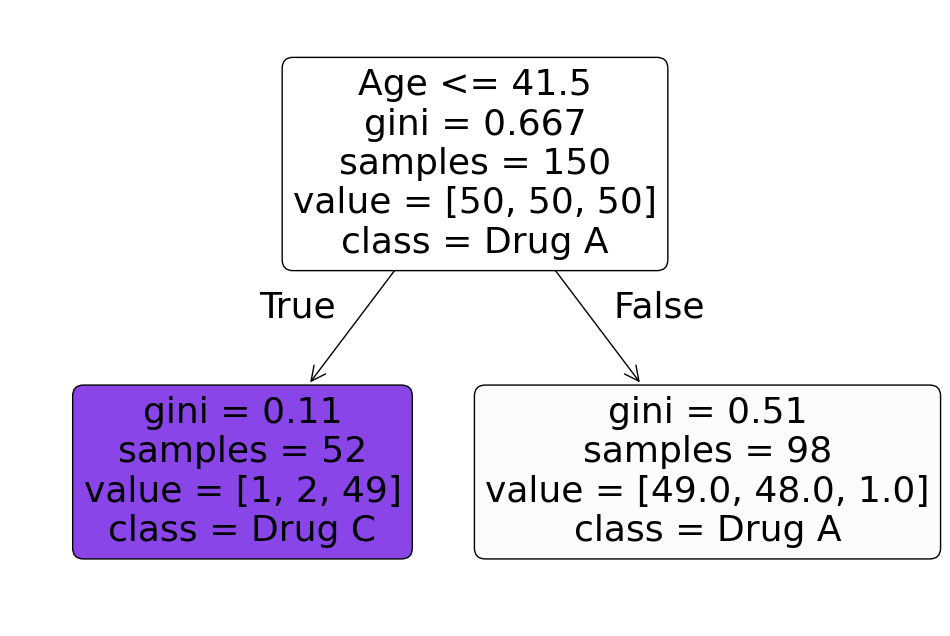

In [4]:
from sklearn.tree import plot_tree
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_clf_shallow, filled=True, feature_names=["Na to K", "Age"], class_names=["Drug A", "Drug B", "Drug C"], rounded=True)
plt.show()

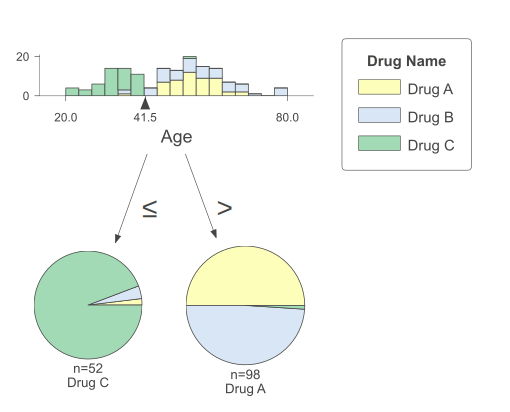

In [5]:
import dtreeviz

viz_model = dtreeviz.model(tree_clf_shallow,
                           X_train=X_biomedical, y_train=y_biomedical,
                           feature_names=["Na to K", "Age"],
                           target_name='Drug Name',
                           class_names=["Drug A", "Drug B", "Drug C"])

viz_model.view(scale=2)     # render as SVG into internal object 

Cada nodo del árbol de decisión tiene varios **atributos importantes**. Por ejemplo, en la **raíz** (profundidad 0) hay un cierto número de instancias; en el nodo de la derecha (profundidad 1), 52 instancias tienen **edad menor que 41.5 años**.

El atributo **value** proporciona el **número de instancias de entrenamiento por clase** contenidas en el nodo (por ejemplo, el nodo derecho incluye 1 de *Drug A*, 2 de *Drug B* y 49 de *Drug C*).

El atributo **gini** mide la **impureza** del nodo. Un nodo es **puro** (*gini* = 0) cuando todas las instancias pertenecen a **una sola clase**.

**Impureza de Gini**:

$$ G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2 $$

donde $p_{i,k}$ es la **proporción** de instancias de la clase $k$ dentro del nodo $i$.
...


### Visualización de fronteras de decisión
Si **representamos** las fronteras de decisión del árbol, podemos ver cómo el modelo toma decisiones en función de la **proporción sodio‑potasio** del paciente y su **edad**.


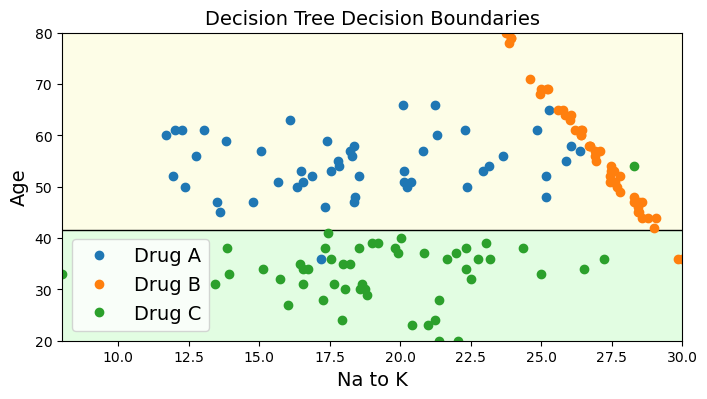

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Custom colormap for plotting
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

# Meshgrid for plotting decision boundaries
NtoK, ages = np.meshgrid(np.linspace(8, 30, 100), np.linspace(20, 80, 100))
X_biomedical_all = np.c_[NtoK.ravel(), ages.ravel()]

# Predicting classes
y_pred = tree_clf_shallow.predict(X_biomedical_all).reshape(NtoK.shape)
plt.contourf(NtoK, ages, y_pred, alpha=0.3, cmap=custom_cmap)
plt.contour(NtoK, ages, y_pred, levels=[1], colors='k', linewidths=1, linestyles=['-','--'])


# Plotting the data points
for idx, label in enumerate(["Drug A", "Drug B", "Drug C"]):
    plt.plot(X_biomedical[:, 0][y_biomedical == idx], X_biomedical[:, 1][y_biomedical == idx],
             "o", label=label)

plt.xlabel("Na to K")
plt.ylabel("Age")
plt.legend()
plt.title("Decision Tree Decision Boundaries")
plt.show()


Si dibujamos las **fronteras de decisión**, vemos que la **línea vertical gruesa** representa la **frontera** del nodo raíz (profundidad 0): `Age = 41.5`.
Dado que `max_depth` se fijó en 1, el árbol de decisión **se detiene ahí**; como resultado, algunas instancias de *Drug C* y *Drug B* quedan esencialmente **mal clasificadas** como *Drug A*.

Si establecemos `max_depth = 2`, entonces cada nodo de profundidad 1 **añadiría otra frontera de decisión** (representada por una línea vertical u horizontal adicional).


In [7]:
# Here, we train Decision tree with max depth set to 3
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_biomedical, y_biomedical)

DecisionTreeClassifier(max_depth=2, random_state=42)

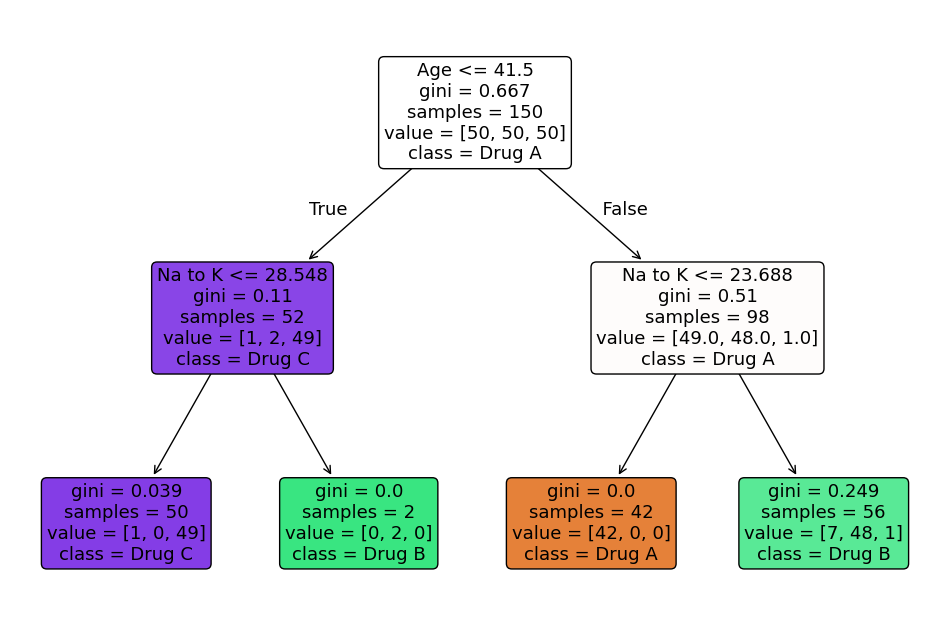

In [8]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, filled=True, feature_names=["Na to K", "Age"], class_names=["Drug A", "Drug B", "Drug C"], rounded=True)
plt.show()

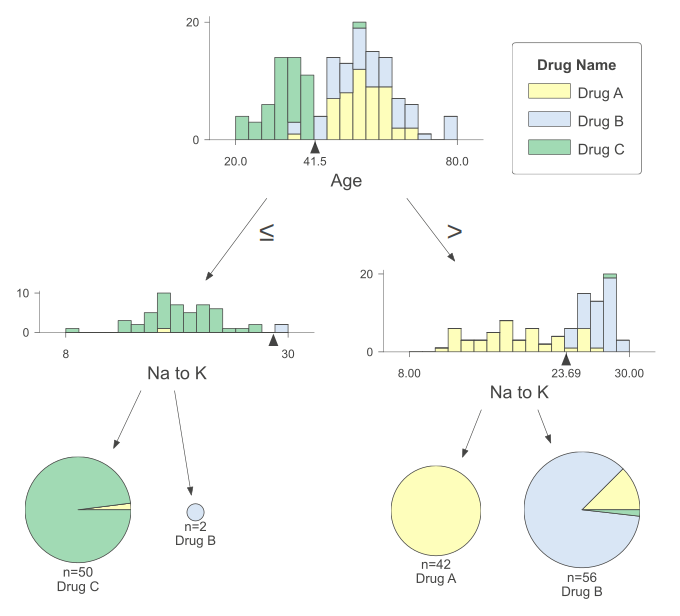

In [9]:
viz_model = dtreeviz.model(tree_clf,
                           X_train=X_biomedical, y_train=y_biomedical,
                           feature_names=["Na to K", "Age"],
                           target_name='Drug Name',
                           class_names=["Drug A", "Drug B", "Drug C"])

viz_model.view(scale=2)    

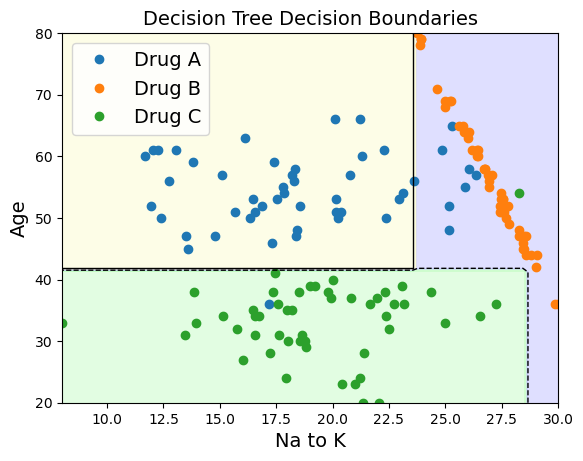

In [10]:
# Plotting the data points
for idx, label in enumerate(["Drug A", "Drug B", "Drug C"]):
    plt.plot(X_biomedical[:, 0][y_biomedical == idx], X_biomedical[:, 1][y_biomedical == idx],
             "o", label=label)

# Predicting classes
y_pred = tree_clf.predict(X_biomedical_all).reshape(NtoK.shape)
plt.contourf(NtoK, ages, y_pred, alpha=0.3, cmap=custom_cmap)
plt.contour(NtoK, ages, y_pred, levels=[0,1], colors='k', linewidths=1, linestyles=['-','--'])

plt.xlabel("Na to K")
plt.ylabel("Age")
plt.legend()
plt.title("Decision Tree Decision Boundaries")
plt.show()

#### Interpretación del modelo: **caja blanca** vs **caja negra**

Como puedes ver, los **árboles de decisión** son bastante **intuitivos** y sus decisiones son **fáciles de interpretar**. A este tipo de modelos se les suele llamar **modelos de caja blanca**. En contraste, como veremos más adelante, modelos como las **redes neuronales** suelen considerarse **cajas negras**.

Si se dejan **sin restricciones**, la estructura del árbol puede **adaptarse** estrechamente a los datos de entrenamiento, probablemente **sobreajustando**. A este tipo de modelo a menudo se le denomina **no paramétrico**: no porque carezca de parámetros (a menudo tiene muchos), sino porque el **número de parámetros** **no está determinado** antes del entrenamiento; la estructura del modelo es libre para **ajustarse a los datos**.


### Algoritmo **CART** (*Classification And Regression Tree*)

`Scikit‑Learn` utiliza el algoritmo **CART**, que produce únicamente **árboles binarios**: los nodos internos siempre tienen **dos hijos** (es decir, las preguntas solo tienen respuestas **sí/no**).

(No obstante, otros algoritmos como **ID3** pueden producir árboles con nodos que tienen **más de dos hijos**.)


La idea de **CART** es bastante simple: el algoritmo **divide primero** el conjunto de entrenamiento en **dos subconjuntos** usando una **característica** $k$ y un **umbral** $t_k$ (por ejemplo, `Age < 41.5`). Recorre todas las características y posibles umbrales y **busca el par** $(k, t_k)$ que produce los **subconjuntos más puros**.

Una vez que ha dividido el conjunto de entrenamiento en dos, **vuelve a dividir** cada subconjunto aplicando la misma lógica, luego los sub‑subconjuntos, y así sucesivamente, de forma **recursiva**.


> Función de coste **CART** para clasificación
>
>$$
J(k,t\_k) = \frac{m_{\mathrm{left}}}{m} , G_{\mathrm{left}} + \frac{m_{\mathrm{right}}}{m} , G_{\mathrm{right}}
$$

donde $G_{\mathrm{left/right}}$ mide la **impureza** del subconjunto izquierdo/derecho, y $m_{\mathrm{left/right}}$ es el **número de instancias** en el subconjunto izquierdo/derecho.

Dado que cada nodo solo requiere comprobar el valor de **una característica**, la **complejidad de predicción** es $O(\log_2 m)$, independiente del **número de características**. Por tanto, las predicciones son **muy rápidas**, incluso con conjuntos de entrenamiento grandes.

Sin embargo, el algoritmo de entrenamiento **compara todas las características** (o un subconjunto) en muchos puntos de corte, lo que da lugar a una **complejidad de entrenamiento** de $O(n \times m \log m)$. Para conjuntos pequeños (menos de unos pocos miles de instancias), `Scikit‑Learn` lo maneja muy bien, pero para conjuntos grandes el entrenamiento puede **ralentizarse** considerablemente.


## Estimación de probabilidades de clase


Un árbol de decisión también puede **estimar la probabilidad** de que una instancia pertenezca a una clase $k$: primero recorre el árbol para encontrar la **hoja** correspondiente a esa instancia y luego devuelve la **razón** de instancias de entrenamiento de la clase $k$ en dicha hoja.


In [11]:
tree_clf.predict([[25, 55]])

array([1])

In [12]:
tree_clf.predict_proba([[25, 55]]).round(3)

array([[0.125, 0.857, 0.018]])

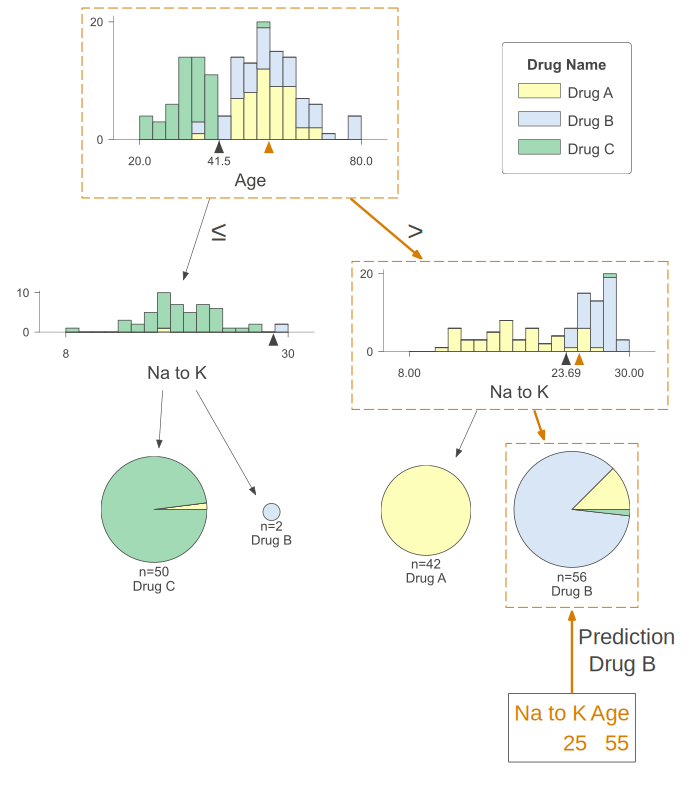

In [13]:
viz_model.view(x=[25,55], scale=2)

## Hiperparámetros de regularización


Los árboles de decisión **hacen muy pocas suposiciones** sobre los datos de entrenamiento (a diferencia de los modelos lineales, que, por ejemplo, suponen linealidad).

Si se dejan **sin restricciones**, la estructura del árbol se **adaptará** a los datos de entrenamiento, ajustándolos muy de cerca y probablemente **sobreajustando**. A un modelo así a menudo se le llama **no paramétrico** —no porque carezca de parámetros (suele tener muchos), sino porque el **número de parámetros no está fijado** antes del entrenamiento, por lo que la estructura del modelo puede **amoldarse** a los datos.


En cambio, un **modelo paramétrico** (como uno lineal) tiene un **número fijo de parámetros**, lo que reduce el riesgo de **sobreajuste** (pero **aumenta** el riesgo de **subajuste**).

Los **hiperparámetros de regularización** dependen del algoritmo empleado y controlan la **forma** del árbol de decisión. En `Scikit‑Learn`, por ejemplo, **reducir** `max_depth` limita la **profundidad máxima** del árbol.


La clase `DecisionTreeClassifier` dispone de otros hiperparámetros que **restringen la forma** del árbol:

- `min_samples_split`: número **mínimo** de muestras que debe tener un nodo antes de poder **dividirse**.
- `min_samples_leaf`: número **mínimo** de muestras que debe tener una **hoja**.
- `min_weight_fraction_leaf`: igual que `min_samples_leaf`, pero expresado como **fracción** del número total de **muestras ponderadas**.


In [14]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

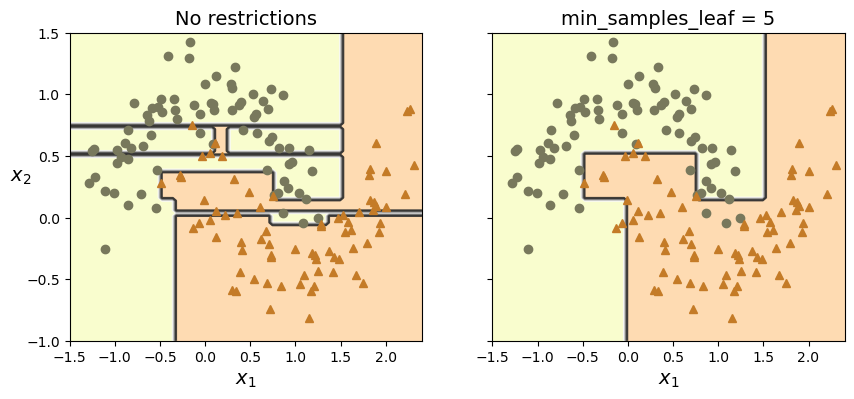

In [15]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

In [16]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [17]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

## Inestabilidad


Los `Decision Trees` son **fáciles de entender e interpretar**, sencillos de usar, **versátiles** y **potentes**.

Sin embargo, presentan algunas **limitaciones**.


### Sensibilidad a la orientación de los ejes


Primero, a los árboles de decisión les gustan las **fronteras de decisión ortogonales** (perpendiculares a algún eje). Por tanto, **rotar** el conjunto de datos también conduce a **fronteras** completamente diferentes:


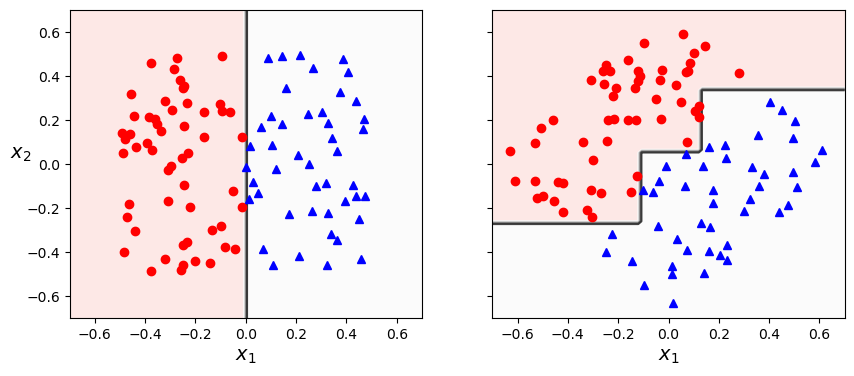

In [18]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()

Tras la **rotación**, la frontera de decisión se ve **innecesariamente enrevesada**. Aunque se ajusta **perfectamente** al conjunto de entrenamiento, es muy probable que el modelo de la derecha **no generalice bien**.


> Una forma de **limitar** este problema es **escalar** los datos y luego aplicar una **rotación** (p. ej., **PCA**), lo que a menudo da lugar a una **mejor orientación** de los datos de entrenamiento.


### Los árboles de decisión tienen alta varianza


En términos generales, el **principal problema** de los árboles de decisión es que presentan una **varianza bastante alta**: 
> pequeños cambios en los **hiperparámetros** o en los **datos** pueden producir **modelos muy diferentes**.

De hecho, **entrenar el mismo modelo** sobre los mismos datos puede producir árboles distintos, porque el algoritmo **CART** usado por `Scikit‑Learn` es **estocástico**.
